In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans

with open('yet-another.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

dataset = pd.read_csv('LUMEN_DS.csv', sep='|', quotechar='"', encoding='UTF-16LE')


/home/borna/environments/lumen/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (16,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
display(dataset)

,Manufacturing Region,Manufacturing Location Code,Intercompany,CustomerID,Customer industry,Customer Region,Customer First Invoice Date,Top Customer Group,Item Code,Product family,...,Invoiced qty (shipped),Ordered qty,Invoiced price,Invoiced price (TX),Cost of part,Material cost of part,Labor cost of part,Overhead cost of part,GM%,# of unique products on a quote
0,North America,N7,YES,224224,IC000,Asia,2009-06-26 00:00:00,OTHER,054501,PF002,...,499.0,499.0,0.3900,0.3900,0.4173,0.3900,0.0000,0.0,-0.070000,1.0
1,North America,N7,NO,230494,IC012,North America,2007-08-08 00:00:00,OTHER,034903,PF002,...,1000.0,1000.0,0.1400,0.1400,0.0257,0.0240,0.0000,0.0,0.816429,3.0
2,Asia,N13,YES,235861,IC000,North America,2008-02-07 00:00:00,OTHER,057280,PF002,...,3.0,3.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,NaN,14.0
3,Asia,N13,NO,223839,IC000,Asia,2003-09-08 00:00:00,OTHER,309146,PF002,...,2000.0,5000.0,0.2000,0.2000,0.0000,0.0000,0.0000,0.0,1.000000,1.0
4,Asia,N13,NO,223839,IC000,Asia,2003-09-08 00:00:00,OTHER,309146,PF002,...,1230.0,5000.0,0.2000,0.2000,0.0000,0.0000,0.0000,0.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294957,Europe,S1,NO,28581,IC003,Europe,2005-09-12 00:00:00,OTHER,NEURO,PF001,...,0.0,1.0,NaN,NaN,0.0000,0.0000,0.0000,0.0,NaN,2.0
1294958,North America,N15,NO,247332,IC008,North America,2014-02-06 00:00:00,OTHER,330-0022,PF002,...,15.0,15.0,7.0000,7.0000,0.7500,0.0000,0.0000,0.0,0.892857,1.0
1294959,North America,N7,NO,228215,IC000,Asia,2005-01-25 00:00:00,OTHER,033411,PF002,...,10000.0,10000.0,0.0702,0.0702,0.0450,0.0450,0.0000,0.0,0.358974,1.0
1294960,North America,N7,NO,235905,IC012,North America,2002-04-02 00:00:00,OTHER,035618,PF002,...,3000.0,3000.0,1.9770,1.9770,1.1336,1.1336,0.0000,0.0,0.426606,1.0


In [3]:
# if we get a tuple of record_id, cluster, unpack it and merge (e.g. yet-another.pkl)
if type(cluster_labels) is tuple:
    if 'Unnamed: 0' not in dataset:
        dataset['Unnamed: 0'] = dataset.index
    
    dataset = dataset.rename(columns={'Unnamed: 0': 'record_id'})
    cluster_labels = pd.DataFrame(zip(cluster_labels[0], cluster_labels[1]), columns=['record_id', 'cluster_id'])
    dataset = dataset.merge(cluster_labels, on='record_id')
    
else: # we just got a list of clusters, hope it maches up
    dataset['cluster_id'] = cluster_labels

dataset = dataset.loc[dataset['GM%'] >= -4]
dataset = dataset.loc[dataset['GM%'] <= 1]

In [4]:
## DROP WHERE # OF DATAPOINTS < 5 (cannot cluster at all)
cluster_sizes = dataset.groupby(['cluster_id']).cluster_id.size()
bad_clusters = cluster_sizes.where(lambda x: x < 5).dropna()
print("dropping clusters: ", bad_clusters.index)

dataset = dataset.loc[~dataset['cluster_id'].isin(bad_clusters.index)]

clusters = dataset.cluster_id.unique()
print("has clusters: ", clusters, " len = ", len(clusters))

dropping clusters:  Int64Index([3, 72], dtype='int64', name='cluster_id')
has clusters:  [86 15 74 78 40  4 59 23  7 63 52 68 84 80 13 65 58 21  8 85 81 34 42 55
 82 41 66 45 79 77 38 53 16 29 87 50 27 37 14  2 56 28 54  1 51 76 17 83
 60 62  0 33 32 57 61 35 47 11 44 69 18 26 71 49 22 46 67 12 30 10 31 19
 25  5 48 20 36 64 24 43 39 73  9  6 75 70]  len =  86


In [5]:
#kmeans = [KMeans(n_clusters=5).fit(np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)) for cid in cluster_labels]

kmeans_objs = [] # list of tuples - cluster id, corresponding KMeans obj
for cid in clusters:
    data = np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)
    #print("training KMeans on {} datapoints for cluster {}".format(data.shape[0], cid))
    kmeans = KMeans(n_clusters=5).fit(data)
    kmeans_objs.append((cid, kmeans))

In [6]:
# dataset diff between max and min GM%
print("in entire dataset, gm% range: ", dataset['GM%'].max() - dataset['GM%'].min())

dgb = dataset.groupby(['cluster_id'])
gm_ranges = (dgb['GM%'].max() - dgb['GM%'].min())
print(gm_ranges)



in entire dataset, gm% range:  5.0
cluster_id
0     4.888889
1     4.944065
2     4.928333
4     4.953966
5     3.303146
        ...   
83    4.571429
84    4.975000
85    4.998483
86    4.978723
87    4.956596
Name: GM%, Length: 86, dtype: float64


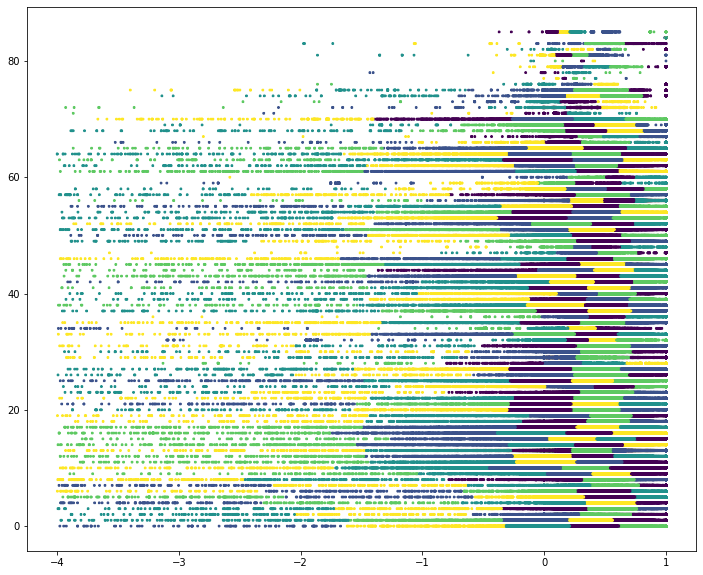

In [7]:
# assign price grades for each cluster centroid/labels
import matplotlib.pyplot as plt
for cid, kmeans in kmeans_objs:
    dataset.loc[dataset.cluster_id == cid, 'price_grade_cluster_ind'] = kmeans.labels_

dataset['price_grade_cluster_ind'] = dataset['price_grade_cluster_ind'].astype(int)


fig = plt.gcf()
fig.set_size_inches(12, 10)

i = 0
for cid in clusters:
    data = dataset.loc[dataset.cluster_id == cid]
    
    plt.scatter(data['GM%'], [i]*data.shape[0], marker='x', s=4,c=data['price_grade_cluster_ind'])
    i+=1
#fig.savefig('test2png.png', dpi=200)


In [8]:
clusters_df = pd.DataFrame(clusters, columns=['cluster_id'])
clusters_df.set_index('cluster_id')

for cid, kmeans in kmeans_objs:
    label_center = sorted(zip(range(5), kmeans.cluster_centers_), key=lambda el: el[1], reverse=True)
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_label'] = label_center[0][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_label'] = label_center[1][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_label'] = label_center[2][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_label'] = label_center[3][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_label'] = label_center[4][0]
    
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_center'] = label_center[0][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_center'] = label_center[1][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_center'] = label_center[2][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_center'] = label_center[3][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_center'] = label_center[4][1]
    
clusters_df = clusters_df.astype({'a_label': int, 'b_label': int, 'c_label': int, 'd_label': int, 'f_label': int})

In [9]:
#assign 'price_grade' column to dataset

for cid in clusters:
    a_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['a_label'])
    b_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['b_label'])
    c_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['c_label'])
    d_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['d_label'])
    f_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['f_label'])

    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == a_label_for_cluster), 'price_grade'] = 'A'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == b_label_for_cluster), 'price_grade'] = 'B'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == c_label_for_cluster), 'price_grade'] = 'C'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == d_label_for_cluster), 'price_grade'] = 'D'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == f_label_for_cluster), 'price_grade'] = 'F'

In [10]:
price_grade_sizes = dataset[['cluster_id', 'price_grade']].groupby(['cluster_id', 'price_grade'], as_index=False).size()
a_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='A'][['cluster_id', 'size']].rename(columns={'size':'a_size'})
b_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='B'][['cluster_id', 'size']].rename(columns={'size':'b_size'})
c_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='C'][['cluster_id', 'size']].rename(columns={'size':'c_size'})
d_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='D'][['cluster_id', 'size']].rename(columns={'size':'d_size'})
f_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='F'][['cluster_id', 'size']].rename(columns={'size':'f_size'})

clusters_df = clusters_df.merge(a_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(b_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(c_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(d_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(f_price_grade_sizes, on=['cluster_id'])

In [11]:

cluster_sizes = dataset.groupby(['cluster_id'], as_index=False).cluster_id.size().rename(columns={'size': 'cluster_size'})
clusters_df = clusters_df.merge(cluster_sizes, on=['cluster_id'])

In [12]:
clusters_df['Adata%'] = 100.0*(clusters_df['a_size']/clusters_df['cluster_size']).round(4)
clusters_df['Bdata%'] = 100.0*(clusters_df['b_size']/clusters_df['cluster_size']).round(4)
clusters_df['Cdata%'] = 100.0*(clusters_df['c_size']/clusters_df['cluster_size']).round(4)
clusters_df['Ddata%'] = 100.0*(clusters_df['d_size']/clusters_df['cluster_size']).round(4)
clusters_df['Fdata%'] = 100.0*(clusters_df['f_size']/clusters_df['cluster_size']).round(4)
clusters_df = clusters_df.sort_values(by='cluster_id')


In [13]:
clusters_df

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_center,b_center,c_center,d_center,...,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
50,0,3,0,2,4,1,0.892435,0.378310,0.061572,-0.629001,...,4038,7980,701,135,14117,8.95,28.60,56.53,4.97,0.96
43,1,2,0,4,1,3,0.827283,0.417331,0.106785,-0.563237,...,11516,6683,1155,177,23440,16.68,49.13,28.51,4.93,0.76
39,2,3,1,0,4,2,0.915864,0.489386,0.211321,-0.454192,...,6918,5370,625,74,15916,18.40,43.47,33.74,3.93,0.46
5,4,2,0,4,1,3,0.989374,0.507763,0.144165,-1.285994,...,2805,2795,142,163,11980,50.71,23.41,23.33,1.19,1.36
73,5,4,0,2,1,3,0.624770,0.244889,0.026224,-0.353818,...,526,361,98,7,1071,7.38,49.11,33.71,9.15,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,83,0,3,1,2,4,0.996034,0.541257,0.320610,-0.124976,...,717,1352,110,15,4273,48.65,16.78,31.64,2.57,0.35
12,84,2,0,4,1,3,0.763303,0.381401,0.066053,-0.586220,...,8760,4498,977,176,17727,18.71,49.42,25.37,5.51,0.99
19,85,0,3,1,2,4,0.925005,0.516644,0.238972,-0.491876,...,8664,8347,780,128,22637,20.84,38.27,36.87,3.45,0.57
0,86,3,0,2,4,1,0.858503,0.368144,0.062398,-0.707940,...,4126,7286,491,103,12986,7.55,31.77,56.11,3.78,0.79


In [14]:

with pd.option_context('display.max_rows', None):
    display(clusters_df[['cluster_id', 'Adata%', 'Bdata%', 'Cdata%', 'Ddata%', 'Fdata%']])

,cluster_id,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
50,0,8.95,28.60,56.53,4.97,0.96
43,1,16.68,49.13,28.51,4.93,0.76
39,2,18.40,43.47,33.74,3.93,0.46
5,4,50.71,23.41,23.33,1.19,1.36
73,5,7.38,49.11,33.71,9.15,0.65
83,6,37.90,42.57,14.29,4.08,1.17
8,7,57.44,21.40,18.43,1.38,1.36
18,8,21.11,44.20,31.94,2.28,0.47
82,9,64.60,8.07,9.52,5.59,12.22
69,10,14.54,26.25,31.26,27.52,0.42


In [15]:
gm_ranges = dataset.groupby(['cluster_id', 'price_grade'], as_index=False).agg({'GM%': ['min', 'max']})
gm_ranges.columns = ['cluster_id', 'price_grade', 'gm%min', 'gm%max']
clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'A'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Agm%min', 'gm%max': 'Agm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'B'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Bgm%min', 'gm%max': 'Bgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'C'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Cgm%min', 'gm%max': 'Cgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'D'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Dgm%min', 'gm%max': 'Dgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'F'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Fgm%min', 'gm%max': 'Fgm%max'})

In [24]:
clusters_df['total_pricing_width'] = clusters_df['Agm%max'] - clusters_df['Fgm%min']
clusters_df['Apricing_width%'] = (100.0*(clusters_df['Agm%max'] - (clusters_df['a_center'] + clusters_df['b_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Bpricing_width%'] = (100.0*((clusters_df['a_center'] + clusters_df['b_center'])/2 - (clusters_df['c_center'] + clusters_df['b_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Cpricing_width%'] = (100.0*((clusters_df['b_center'] + clusters_df['c_center'])/2 - (clusters_df['c_center'] + clusters_df['d_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Dpricing_width%'] = (100.0*((clusters_df['c_center'] + clusters_df['d_center'])/2 - (clusters_df['d_center'] + clusters_df['f_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Fpricing_width%'] = (100.0*((clusters_df['d_center'] + clusters_df['f_center'])/2 - clusters_df['Fgm%min'])/clusters_df['total_pricing_width']).round(2)


In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(clusters_df)

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_center,b_center,c_center,d_center,f_center,a_size,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%,Agm%min,Agm%max,Bgm%min,Bgm%max,Cgm%min,Cgm%max,Dgm%min,Dgm%max,Fgm%min,Fgm%max,total_pricing_width,Apricing_width%,Bpricing_width%,Cpricing_width%,Dpricing_width%,Fpricing_width%
0,0,3,0,2,4,1,0.892435,0.378310,0.061572,-0.629001,-2.287018,1263,4038,7980,701,135,14117,8.95,28.60,56.53,4.97,0.96,0.636364,1.000000,0.220021,0.634769,-0.283525,0.219941,-1.445455,-0.284515,-3.888889,-1.465000,4.888889,7.46,8.50,10.30,24.02,49.72
1,1,2,0,4,1,3,0.827283,0.417331,0.106785,-0.563237,-2.359695,3909,11516,6683,1155,177,23440,16.68,49.13,28.51,4.93,0.76,0.622353,1.000000,0.262079,0.622262,-0.227924,0.262033,-1.461111,-0.228325,-3.944065,-1.470588,4.944065,7.64,7.29,9.92,24.94,50.21
2,2,3,1,0,4,2,0.915864,0.489386,0.211321,-0.454192,-2.462352,2929,6918,5370,625,74,15916,18.40,43.47,33.74,3.93,0.46,0.703056,1.000000,0.350420,0.702134,-0.120000,0.350268,-1.430676,-0.121880,-3.928333,-1.496869,4.928333,6.03,7.15,9.57,27.13,50.12
3,4,2,0,4,1,3,0.989374,0.507763,0.144165,-1.285994,-2.989448,6075,2805,2795,142,163,11980,50.71,23.41,23.33,1.19,1.36,0.749942,1.000000,0.326189,0.748529,-0.568216,0.325712,-2.119651,-0.592597,-3.953966,-2.146556,4.953966,5.08,8.53,18.10,31.63,36.66
4,5,4,0,2,1,3,0.624770,0.244889,0.026224,-0.353818,-1.702375,79,526,361,98,7,1071,7.38,49.11,33.71,9.15,0.65,0.442628,0.828436,0.136734,0.419573,-0.142745,0.135173,-0.753537,-0.213725,-2.474710,-1.180684,3.303146,11.92,9.06,9.06,26.17,43.80
5,6,0,3,1,4,2,0.810799,0.493978,0.170109,-0.536927,-1.913939,130,146,49,14,4,343,37.90,42.57,14.29,4.08,1.17,0.653878,1.000000,0.337184,0.650862,-0.063290,0.323797,-1.068346,-0.202708,-1.977149,-1.736989,2.977149,11.68,10.76,17.31,35.00,25.25
6,7,1,3,0,2,4,0.989275,0.492034,0.130399,-1.712497,-3.211688,8266,3079,2652,198,195,14390,57.44,21.40,18.43,1.38,1.36,0.741190,1.000000,0.311814,0.740468,-0.783883,0.311216,-2.456607,-0.824286,-3.994211,-2.470532,4.994211,5.19,8.60,22.07,33.46,30.68
7,8,1,3,0,2,4,0.923469,0.482946,0.212389,-0.566631,-2.361670,4630,9693,7004,500,103,21930,21.11,44.20,31.94,2.28,0.47,0.703235,1.000000,0.347692,0.703148,-0.176250,0.347572,-1.456991,-0.177718,-3.850840,-1.496364,4.850840,6.12,7.33,10.82,26.53,49.20
8,9,0,3,1,4,2,0.999404,0.599837,0.497860,0.301262,0.045410,312,39,46,27,59,483,64.60,8.07,9.52,5.59,12.22,0.814126,1.000000,0.556351,0.666667,0.435000,0.543590,0.185142,0.395926,-0.303665,0.152024,1.303665,15.37,19.24,11.45,17.35,36.59
9,10,1,4,0,3,2,0.981791,0.529228,0.297412,0.030185,-1.523251,1442,2603,3100,2729,42,9916,14.54,26.25,31.26,27.52,0.42,0.756098,1.000000,0.413333,0.755102,0.163934,0.413228,-0.678571,0.163121,-3.116667,-0.768473,4.116667,5.94,8.31,6.06,22.11,57.57
